In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

Model Architecture

In [4]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [5]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # 线性变化层
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        # log-sofrmax输出
        return F.log_softmax(self.proj(x), dim=-1)

Encoder

In [6]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

在两个子层中的每一个周围使用残差连接,随后是归一化层

In [8]:
class LayerNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        meax = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - meax) / (std + self.eps) + self.b_2

In [9]:
class SublayerConnection(nn.Module):
    """
    在两个子层中的每一个周围使用残差连接,随后是归一化层
    """
    
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        "将残差连接应用于任何具有相同大小的子层。"
        return x + self.dropout(sublayer(self.norm(x)))

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 第一子层操作
        # 等价于：
        # 1. 计算自注意力：self.self_attn(x, x, x, mask)
            # 这里：query = x, key = x, value = x
            # 因为是自注意力，所以Q、K、V都来自同一个输入
        # 2. 执行残差连接：x + dropout(attention_output)
        # 3. 层归一化：LayerNorm(x + dropout(attention_output))
        
        return self.sublayer[1](x, self.feed_forward)
        # 第二子层操作
        # 等价于：
        # 1. 计算前馈网络：self.feed_forward(x)
        # 2. 执行残差连接：x + dropout(ffn_output)  
        # 3. 层归一化：LayerNorm(x + dropout(ffn_output))

Decoder

In [11]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [12]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 第一子层：掩码自注意力
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 第二子层：编码器-解码器注意力
        return self.sublayer[2](x, self.feed_forward)
        # 第三子层：前馈网络

In [13]:
def subsequent_mask(size):
    
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

Attention

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    "计算 缩放点积注意力"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
    

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # 假设d_v = d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.

            # mask维度扩展 增加head维度
            # mask维度：[batch_size, seq_len]
            # 注意力维度：[batch_size, h, seq_len, seq_len]
            # 两个维度不匹配 给mask在第一个维度(索引从0开始)插入大小为1的维度
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 2) Apply attention on all the projected vectors in batch.
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 3) "Concat" using a view and apply a final linear.
        return self.linears[-1](x)

Position-wise Feed-Forward Networks

In [16]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation 位置级前馈神经网络."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff) # 扩张层: 512 -> 2048
        self.w_2 = nn.Linear(d_ff, d_model) # 压缩层: 2048 -> 512
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU() # 非线性激活函数

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        # 对序列中的每一个位置独立进行相同的操作
        return self.w_2(self.dropout(self.activation(self.w_1(x))))
        # 1. self.w_1(x): [batch, seq, d_model] -> [batch, seq, d_ff]
        # 2. activation(...): 非线性变换 [batch, seq, d_ff]
        # 3. dropout(...): 随机失活，防止过拟合 [batch, seq, d_ff]
        # 4. self.w_2(...): [batch, seq, d_ff] -> [batch, seq, d_model]

Embeddings and Softmax

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) *  math.sqrt(self.d_model)

Positional Encoding

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *- (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

Full Model

In [19]:
def make_model(src_vocab:int, tgt_vocab:int, N:int=6, d_model:int=512, d_ff:int=2048, h:int=8, dropout:float=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

# Training

Batches and Masking

In [20]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            
            # Transformer是自回归的，输入前n-1个token，预测后n-1个token
            # 解码器的输入（去掉最后一个token）
            self.trg = trg[:, :-1]

            # 解码器目标（去掉第一个token）
            self.trg_y = trg[:, 1:]
            
            
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        
        # 将矩阵是pad填充的值置为False
        tgt_mask = (tgt != pad).unsqueeze(-2)
        
        # 只有值不为pad且在预测位置i之前的值的才能被Encoder看到
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

Training Loop

In [21]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == i:
            elapsed = time.time() - start
            print(f"Epoch Step: {i} Loss: {loss / batch.ntokens} Tokens per Sec: {tokens/elapsed}")
            start = time.time()
            tokens = 0
    
    return total_loss / total_tokens

Training Data and Batching

In [22]:
global max_src_in_batch, max_tgt_in_batch

# 动态批次大小控制函数
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)    
    

Optimizer

Noam调度器

1. 训练初期缓慢增加：给模型一个热身期，让参数稳定地进入一个好的优化区域
2. 训练后期缓慢衰减：在训练后期逐渐降低学习率，帮助模型收敛。


In [23]:
# Noam调度器 Transformer学习率调度器 带热启动的平方根倒数调度器
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        # 底层优化器，为Adam
        self.optimizer = optimizer      
        self._step = 0
        
        # 热启动步数，关键的超参数（通常为4000或8000
        self.warmup = warmup
        
        # 缩放因子 控制学习率大小
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        # 计算当前step的学习率
        for p in self.optimizer.param_groups:
            p['lr'] = rate
            # 更新优化器的学习率
        self._rate = rate
        self.optimizer.step()
    
    # 学习率计算
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        # 基础缩放 self.model_size ** (-0.5)，与模型维度的平方根成反比，补偿更大模型维带来的梯度幅度变化
        # min函数控制两个阶段
            # 阶段1：热启动期（学习率递增）
            # 当 step 较小时，step * warmup^(-1.5) 的值小于 step^(-0.5)。
            # 此时学习率公式简化为：factor × d_model^(-0.5) × step × warmup^(-1.5)
            # 学习率与 step 成正比线性增长。
            # 阶段2：衰减期（学习率递减）
            # 当 step 超过 warmup 后，step^(-0.5) 的值小于 step × warmup^(-1.5)。
            # 此时学习率公式简化为：factor × d_model^(-0.5) × step^(-0.5)
            # 学习率与 step 的平方根成反比衰减。
        

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, 
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

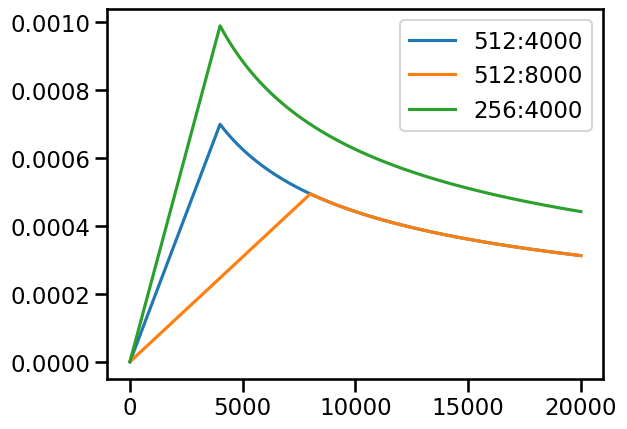

In [24]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

# Regularization

Label Smoothing

问题：传统的交叉熵损失使用"硬标签"（一个类为1，其他为0），这会导致：

1. 过拟合：模型过度自信，对训练数据拟合太好。
2. 校准差：预测概率不能反映真实的不确定性。
3. 泛化弱：对噪声标签敏感。

解决方案：标签平滑将"硬标签"变为"软标签"，让正确的类别概率接近1但不等于1，错误的类别也有小概率。

In [25]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size:int, padding_idx:int, smoothing:float=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False) # KL散度损失 因为我们要比较两个概率分布
        self.padding_idx = padding_idx # 填充pad的索引
        self.confidence = 1.0 - smoothing # 正确标签的概率
        self.smoothing = smoothing # 平滑值 如0.1 意味着正确类别概率为0.9，其他类别共享0.1的概率。
        self.size = size  # 词汇表大小
        self.true_dist = None # 存储生成的目标分布（用于调试
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        # 确保模型输出维度与词汇表大小一致
        true_dist = x.data.clone()
        # 创建与模型输出 x 相同形状的张量
        true_dist.fill_(self.smoothing / (self.size - 2))
        # 用均匀小概率填充所有位置 分母-2要排除正确类别和填充符
        
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

# A First Example

Synthetic Data

In [26]:
def data_gen(V: int, batch: int, nbatches: int):
    # V 词汇表大小
    # batch 每个batch的样本数量
    # nbatches batch数
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        # np.random.randint(1, V, size=(batch, 10)) 生成一个形状为 (batch, 10) 的二维数组,数值范围从1到V-1
        data[:, 0] = 1
        # 将每个序列的第一个元素设置为1，作为序列的起始标记<sos>
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        # 因为是输入计算，不需要梯度计算
        yield Batch(src, tgt, 0)

Loss Computation

In [29]:
class SimpleLossCompute:
    
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        # 计算损失时，将输出和目标张量展平为二维张量
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

Greedy Decoding

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                   SimpleLossCompute(model.generator, criterion, None)))


In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8, 10,  9]])
